

---


# Class incremental learning on the GTSRB dataset



---


This notebook contains several code snippets to help for your project:

- data loaders
- A baseline for incremental learning using fine-tuning
- Examples of how to use Weight & Biases for logging your results.



In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torchvision.utils import make_grid
from torchvision import transforms, datasets
import torchvision.models as models
from torchvision.transforms import v2
import copy

from torch.optim import lr_scheduler
import torch.nn.init as init

# Evaluation
from src.model import *
from src.utils.data_load import *
from src.utils.data_prep import *



import numpy as np
import random
import time, os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import polars as pl

import math

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
# Check if GPU is available
if torch.cuda.is_available():
  !nvidia-smi

Fri Feb 14 11:57:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2060        Off |   00000000:01:00.0 Off |                  N/A |
| N/A   44C    P3             19W /   50W |       9MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Loading and preparing the data

In [13]:
root_dir = './data'

train_dataset = datasets.GTSRB(root=root_dir, split='train', download=False, transform=transform_train_2)
test_dataset = datasets.GTSRB(root=root_dir, split='test', download=False, transform=transform_test_2)

print(f"Train dataset contains {len(train_dataset)} images")
print(f"Test dataset contains {len(test_dataset)} images")

Train dataset contains 26640 images
Test dataset contains 12630 images


In [14]:
test_target = list(pl.read_csv('test_target.csv',separator = ',', has_header=False).row(0))

train_target = list(pl.read_csv('train_target.csv',separator = ',', has_header=False).row(0))

class_names = list(pl.read_csv('signnames.csv')['SignName'])

## Display of images

In [15]:
nclasses = len(np.unique(train_target))
all_classes = list(range(nclasses))
classes_per_task = 8
current_classes = []

task = 1
task_classes = all_classes[task * classes_per_task : (task + 1) * classes_per_task]
current_classes.extend(task_classes)
batch_size = 64

In [16]:
train_loader = create_dataloader(train_dataset, train_target, current_classes, batch_size, shuffle = True)
test_loader = create_dataloader(train_dataset, train_target, current_classes, batch_size, shuffle = True)

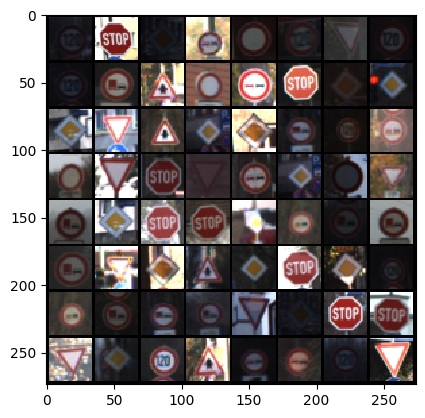

torch.Size([64, 3, 32, 32])


In [17]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

sample,targets = next(iter(train_loader))
show(make_grid(sample))
plt.show()

print(sample.shape)

In [18]:
from collections import Counter

label_counts = Counter(test_target).most_common()
for l, c in label_counts:
    print(c, '\t', l, '\t', class_names[l])

750 	 2 	 Speed limit (50km/h)
720 	 1 	 Speed limit (30km/h)
720 	 13 	 Yield
690 	 38 	 Keep right
690 	 12 	 Priority road
660 	 4 	 Speed limit (70km/h)
660 	 10 	 No passing for vechiles over 3.5 metric tons
630 	 5 	 Speed limit (80km/h)
480 	 25 	 Road work
480 	 9 	 No passing
450 	 7 	 Speed limit (100km/h)
450 	 3 	 Speed limit (60km/h)
450 	 8 	 Speed limit (120km/h)
420 	 11 	 Right-of-way at the next intersection
390 	 18 	 General caution
390 	 35 	 Ahead only
360 	 17 	 No entry
270 	 14 	 Stop
270 	 31 	 Wild animals crossing
210 	 33 	 Turn right ahead
210 	 15 	 No vechiles
180 	 26 	 Traffic signals
150 	 16 	 Vechiles over 3.5 metric tons prohibited
150 	 23 	 Slippery road
150 	 30 	 Beware of ice/snow
150 	 28 	 Children crossing
150 	 6 	 End of speed limit (80km/h)
120 	 34 	 Turn left ahead
120 	 22 	 Bumpy road
120 	 36 	 Go straight or right
90 	 21 	 Double curve
90 	 20 	 Dangerous curve to the right
90 	 24 	 Road narrows on the right
90 	 29 	 Bicycles cr

## Simple networks

In [19]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self,n_out=10, n_in=1):
        super().__init__()

        # Put the layers here
        self.conv1 = nn.Conv2d(n_in, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.fc = nn.Linear(4096, n_out)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x)) ## l'image 1x32x32 devient 32x32x32
        x = F.max_pool2d(x, kernel_size=2, stride=2) ## puis 32x16x16
        x = F.leaky_relu(self.conv2(x)) ## puis devient 64x16x16
        x = F.max_pool2d(x, kernel_size=2, stride=2) ## puis devient 64x8x8
        x = F.leaky_relu(self.conv3(x)) ## pas de changement

        x = x.view(-1,4096) ## 64x8x8 devient 4096

        x = self.fc(x) ## on finit exactement de la même façon

        return x

In [20]:
from torchinfo import summary
model = SimpleCNN(n_out=10, n_in=3)
model.to(device)
print(summary(model, input_size=(batch_size, 3, 32, 32)))


Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [64, 10]                  --
├─Conv2d: 1-1                            [64, 32, 32, 32]          2,432
├─Conv2d: 1-2                            [64, 64, 16, 16]          18,496
├─Conv2d: 1-3                            [64, 64, 8, 8]            36,928
├─Linear: 1-4                            [64, 10]                  40,970
Total params: 98,826
Trainable params: 98,826
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 616.30
Input size (MB): 0.79
Forward/backward pass size (MB): 27.27
Params size (MB): 0.40
Estimated Total Size (MB): 28.45


## Baseline for incremental learning

## Pre-Training

In [21]:
# Hyperparameters
root_dir = './data'  # Path to GTSRB dataset
num_tasks = 5
numclasses = len(np.unique(train_target))
classes_per_task = numclasses // num_tasks #43/2 ~ 20
batch_size = 
lr = 1e-2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

buffer_size = 200 # Adjust rehearsal set size
alignment_strength = 0.1 # Adjust alignment strength
num_epochs = 4

#model = SimpleCNN(n_out = 1, n_in = 3).to(device)
#model.apply(initialize_weights)

# The name of the network (choose the on you want)
tag = "simpleCNN_GTSRB_pretrained"
netname = os.path.join(root_dir, 'network_{:s}.pth'.format(tag))

#################################################
## Pre-training
####

# Read the last learned network (if stored)
if (os.path.exists(netname)):
    print('Load pre-trained network')
    model = SimpleCNN(n_in = 3, n_out=classes_per_task)
    model.load_state_dict(torch.load(netname,weights_only=True))

    #model = torch.load(netname, weights_only=True)
    model = model.to(device)
else:
    print('Pretrain')
    model = SimpleCNN(n_in = 3, n_out=1)
    model.apply(initialize_weights)
    model.to(device)

    accu = incremental_learning(model, train_dataset, train_target, test_dataset, test_target,
                        1, classes_per_task, batch_size, num_epochs, lr, device)

    print(f"!!!!! Pre-training on first task  = {accu[0]:.2f}%")

    # Save last learned model
    #torch.save(model, netname)
    torch.save(model.state_dict(), netname)

## Copy model to have the same initialization
copy_model = copy.deepcopy(model) # Copy model to start from the same initialization

#### Learn with a single epoch in incremental (faster but less accurate)
num_epochs = 1


Load pre-trained network


## Fine tuning

In [22]:
import numpy as np
model = copy.deepcopy(copy_model)
incremental_learning(model, train_dataset, train_target, test_dataset, test_target,
                      num_tasks, classes_per_task, batch_size, num_epochs, lr, device)


Starting Task 1 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7]


100%|█████████████████████████████████████████| 125/125 [00:12<00:00, 10.30it/s]


Task 1, Epoch 1: Accuracy Train = 94.58%


100%|███████████████████████████████████████████| 61/61 [00:05<00:00, 10.20it/s]


Task 1: Accuracy Test = 85.97%
Starting Task 2 - Training on classes: [8, 9, 10, 11, 12, 13, 14, 15]


100%|█████████████████████████████████████████| 126/126 [00:10<00:00, 11.71it/s]


Task 2, Epoch 1: Accuracy Train = 99.24%


100%|█████████████████████████████████████████| 122/122 [00:10<00:00, 11.18it/s]


Task 2: Accuracy Test = 47.45%
Starting Task 3 - Training on classes: [16, 17, 18, 19, 20, 21, 22, 23]


100%|███████████████████████████████████████████| 49/49 [00:03<00:00, 13.86it/s]


Task 3, Epoch 1: Accuracy Train = 96.73%


100%|█████████████████████████████████████████| 144/144 [00:10<00:00, 13.70it/s]


Task 3: Accuracy Test = 12.53%
Starting Task 4 - Training on classes: [24, 25, 26, 27, 28, 29, 30, 31]


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 12.47it/s]


Task 4, Epoch 1: Accuracy Train = 90.09%


100%|█████████████████████████████████████████| 167/167 [00:13<00:00, 12.38it/s]


Task 4: Accuracy Test = 10.32%
Starting Task 5 - Training on classes: [32, 33, 34, 35, 36, 37, 38, 39]


100%|███████████████████████████████████████████| 60/60 [00:04<00:00, 12.64it/s]


Task 5, Epoch 1: Accuracy Train = 98.94%


100%|█████████████████████████████████████████| 194/194 [00:16<00:00, 11.72it/s]

Task 5: Accuracy Test = 12.87%


[85.96899224806202,
 47.45173745173745,
 12.527233115468409,
 10.31924882629108,
 12.865213882163035]

## Upper bound

In [23]:
model = copy.deepcopy(copy_model)
accu = incremental_learning(model, train_dataset, train_target, test_dataset, test_target,
                      1, (numclasses // num_tasks) * num_tasks, batch_size, 5, lr, device)

print(f"!!!!! Upper bound of accuracy = {accu[0]:.2f}%")


Starting Task 1 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


100%|█████████████████████████████████████████| 407/407 [00:28<00:00, 14.32it/s]


Task 1, Epoch 1: Accuracy Train = 98.04%


100%|█████████████████████████████████████████| 407/407 [00:35<00:00, 11.62it/s]


Task 1, Epoch 2: Accuracy Train = 99.12%


100%|█████████████████████████████████████████| 407/407 [00:32<00:00, 12.66it/s]


Task 1, Epoch 3: Accuracy Train = 99.78%


100%|█████████████████████████████████████████| 407/407 [00:31<00:00, 13.10it/s]


Task 1, Epoch 4: Accuracy Train = 99.39%


100%|█████████████████████████████████████████| 407/407 [00:27<00:00, 14.94it/s]


Task 1, Epoch 5: Accuracy Train = 99.80%


100%|█████████████████████████████████████████| 194/194 [00:13<00:00, 14.56it/s]

Task 1: Accuracy Test = 89.48%
!!!!! Upper bound of accuracy = 89.48%
